# **Banking Client Segmentation using K-Medoids**

This notebook implements a **complete clustering pipeline** for **banking clients segmentation** using the **K-Medoids algorithm**.

## **Pipeline Overview:**
1. **Load & Preprocess Data** (Handling categorical & numerical features)
2. **Compute Gower Distance** (for mixed data types)
3. **Apply K-Medoids Clustering**
4. **Evaluate Clustering Performance**
5. **Visualize Results using t-SNE**
6. **Interpret the Clusters** (Understanding the characteristics of each group)


In [10]:
import pandas as pd
import numpy as np

# Load dataset (Update path if necessary)
path = '/Users/mouadh/Fintech_Projects/Business_Case_1/Dataset1_BankClients.xlsx'
data = pd.read_excel(path)

# Drop ID column if present
if 'ID' in data.columns:
    df = data.drop(columns=['ID'])

# Display first 5 rows
df.head()

,Age,Gender,Job,Area,CitySize,FamilySize,Income,Wealth,Debt,FinEdu,ESG,Digital,BankFriend,LifeStyle,Luxury,Saving,Investments
0,24,1,1,2,2,4,0.668046,0.702786,0.262070,0.741853,0.483684,0.698625,0.618259,0.607877,0.897369,0.283222,1
1,47,1,2,2,3,1,0.858453,0.915043,0.730430,0.859423,0.537167,0.959025,0.785936,0.862271,0.913729,0.821590,3
2,38,0,2,1,2,2,0.926818,0.898316,0.441272,0.485953,0.649434,0.750265,0.699725,0.755404,0.765199,0.503790,3
3,67,0,2,1,2,3,0.538797,0.423180,0.600401,0.493144,0.533829,0.590165,0.675353,0.334432,0.517209,0.691240,2
4,33,0,2,1,3,1,0.806659,0.731404,0.831449,0.856286,0.784940,0.710026,0.758793,0.908878,0.611610,0.615916,2


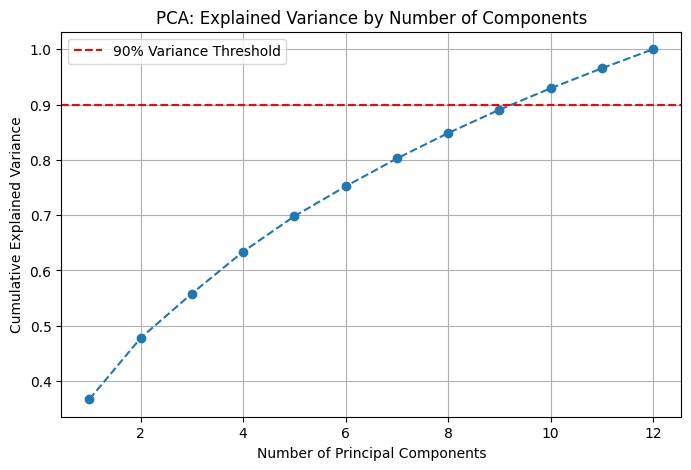

Processed Data Shape: (5000, 21)
Expected Columns: 21, Actual Shape: 21
      PCA_1     PCA_2     PCA_3     PCA_4     PCA_5     PCA_6     PCA_7  \
0  1.657934  0.459028 -0.978825 -2.244287  0.877004 -0.263591 -1.029372   
1  4.789814 -0.072844 -0.382405  0.092595 -1.239877  0.126797  0.288586   
2  2.667048 -0.560942 -0.629649 -0.640127  0.154334 -0.740480 -1.097039   
3  0.046274  0.678199  0.659775  0.367287 -0.229333  0.162076  0.974848   
4  3.808080 -0.671991 -0.716316  0.418620  0.318433  0.595961  0.901428   

      PCA_8     PCA_9    PCA_10  ...  Job_2  Job_3  Job_4  Job_5  Area_2  \
0 -0.033418 -0.455660  1.264148  ...    0.0    0.0    0.0    0.0     1.0   
1 -0.279813  0.504755  0.204069  ...    1.0    0.0    0.0    0.0     1.0   
2  0.306435  0.204195 -0.842285  ...    1.0    0.0    0.0    0.0     0.0   
3  0.282434  0.207084 -0.004886  ...    1.0    0.0    0.0    0.0     0.0   
4  0.035986 -0.393837 -0.315179  ...    1.0    0.0    0.0    0.0     0.0   

   Area_3  CitySize_

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from scipy.stats.mstats import winsorize

# Load dataset
df_cleaned = df.copy()

# Identify categorical and numerical columns
categorical_columns = ['Gender', 'Job', 'Area', 'CitySize', 'Investments']
numerical_columns = df_cleaned.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_columns = [col for col in numerical_columns if col not in categorical_columns]

numerical_features = df_cleaned[numerical_columns]
categorical_features = df_cleaned[categorical_columns]

# Handle Outliers using Winsorization (Clipping extreme 1%)
for col in numerical_features.columns:
    numerical_features.loc[:, col] = winsorize(numerical_features[col], limits=[0.01, 0.01])

# Feature Scaling using StandardScaler
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(numerical_features)

# Compute Correlation Matrix and Identify Highly Correlated Features
corr_matrix = numerical_features.corr().abs()
high_corr_var = np.where(corr_matrix > 0.85)
high_corr_pairs = [(corr_matrix.index[i], corr_matrix.columns[j]) for i, j in zip(*high_corr_var) if i != j]

# Drop redundant numerical features
features_to_drop = list(set([pair[1] for pair in high_corr_pairs]))
numerical_features_reduced = numerical_features.drop(columns=features_to_drop)
X_num_scaled_reduced = scaler.fit_transform(numerical_features_reduced)

# PCA for Dimensionality Reduction
pca = PCA()
pca.fit(X_num_scaled_reduced)
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Determine the number of components for 90% variance
optimal_components = np.argmax(explained_variance >= 0.90) + 1

# Fit PCA with optimal number of components
pca = PCA(n_components=optimal_components)
X_pca = pca.fit_transform(X_num_scaled_reduced)

# Plot Explained Variance to determine optimal components
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA: Explained Variance by Number of Components")
plt.axhline(y=0.90, color='r', linestyle='--', label="90% Variance Threshold")
plt.legend()
plt.grid()
plt.show()

# One-Hot Encoding for Categorical Features
encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
X_cat = encoder.fit_transform(categorical_features).toarray()

# Concatenate Processed PCA and Encoded Categorical Features
X_preprocessed = np.hstack((X_pca, X_cat))

# Display final processed dataset shape
print(f'Processed Data Shape: {X_preprocessed.shape}')

# Correggi il numero di nomi di colonne per PCA
num_pca_components = X_pca.shape[1]
pca_col_names = [f'PCA_{i+1}' for i in range(num_pca_components)]

# Ottieni il numero corretto di colonne per le categorie
cat_col_names = encoder.get_feature_names_out(categorical_columns)

# Assicurati che il numero di colonne combaci
expected_columns = np.concatenate((pca_col_names, cat_col_names))
print(f"Expected Columns: {len(expected_columns)}, Actual Shape: {X_preprocessed.shape[1]}")

# Controllo preventivo per evitare errori di forma
if X_preprocessed.shape[1] != len(expected_columns):
    raise ValueError(f"Mismatch in column counts! Processed Data Shape: {X_preprocessed.shape}, Expected Columns: {len(expected_columns)}")

# Crea il DataFrame corretto
preprocessed_df = pd.DataFrame(X_preprocessed, columns=expected_columns)
print(preprocessed_df.head())

numerical_prof_columns=['Income','Wealth','Debt','LifeStyle','Luxury','Age']
numerical_prof_features = data[numerical_prof_columns]
numerical_finedu_features = data.drop(columns=categorical_columns + numerical_prof_columns)
X_num_prof=scaler.fit_transform(numerical_prof_features)
X_num_finedu=scaler.fit_transform(numerical_finedu_features)



In [12]:
import gower
from scipy.spatial.distance import pdist, squareform

def hamming_cityblock_distance_matrix(X_num, X_cat, num_weight=12/17, cat_weight=5/17):
    # Uses Cityblock (Manhattan) for numerical features
    # Uses Hamming for categorical features
    # Combines them with custom weights

    num_dist = pdist(X_num, metric='cityblock')
    cat_dist = pdist(X_cat, metric='hamming')  # Convert sparse matrix to dense

    # Combine the distances with assigned weights
    combined_dist = (num_weight * num_dist) + (cat_weight * cat_dist)

    return squareform(combined_dist)  # Square matrix

def tanimoto_cityblock_distance_matrix(X_num, X_cat, num_weight=12/17, cat_weight=5/17):
    # Uses Cityblock (Manhattan) for numerical variables
    # Uses Tanimoto (Jaccard) for binary categorical variables
    # Combines the distances with custom weights

    num_dist = pdist(X_num, metric='cityblock')
    cat_dist = pdist(X_cat, metric='jaccard')  # Convert sparse matrix to dense

    # Combine the distances with assigned weights
    combined_dist = (num_weight * num_dist) + (cat_weight * cat_dist)

    return squareform(combined_dist)  # Square matrix

def hamming_cityblock_distance_matrix_new(X_num_prof, X_num_finedu, X_cat, prof_weight=7/17, finedu_weight=5/17, cat_weight=5/17): #using their number
    #Usa Cityblock (Manhattan) per le numeriche
    #Usa Hamming per le categoriche
    #- Combina con pesi personalizzati

    num_prof_dist = pdist(X_num_prof, metric='cityblock')
    num_finedu_dist = pdist(X_num_finedu, metric='cityblock')
    cat_dist = pdist(X_cat, metric='hamming')

    # Combina le distanze con i pesi assegnati
    combined_dist = (prof_weight * num_prof_dist) + (finedu_weight * num_finedu_dist) + (cat_weight * cat_dist)

    return squareform(combined_dist)  # Matrice quadrata

def tanimoto_cityblock_distance_matrix_new(X_num_prof, X_num_finedu, X_cat, prof_weight=7/17, finedu_weight=5/17, cat_weight=5/17):

    #Usa Cityblock (Manhattan) per le variabili numeriche
    #Usa Tanimoto (Jaccard) per le variabili categoriche binarie
    #Combina le distanze con pesi personalizzati

    num_prof_dist = pdist(X_num_prof, metric='cityblock')
    num_finedu_dist = pdist(X_num_finedu, metric='cityblock')
    cat_dist = pdist(X_cat, metric='jaccard')  # Jaccard è equivalente a Tanimoto

    # Combina le distanze con i pesi assegnati
    combined_dist = (prof_weight * num_prof_dist) + (finedu_weight * num_finedu_dist) + (cat_weight * cat_dist)

    return squareform(combined_dist)  # Matrice quadrata

# Create custom distance matrices
hammingCityblock_distance = hamming_cityblock_distance_matrix(X_num_scaled_reduced, X_cat)
tanimotoCityblock_distance = tanimoto_cityblock_distance_matrix(X_num_scaled_reduced, X_cat)

# Creazione della matrice delle distanze personalizzate
hamming_dist_matrix_new = hamming_cityblock_distance_matrix_new(X_num_prof, X_num_finedu, X_cat)
tanimoto_dist_matrix_new = tanimoto_cityblock_distance_matrix_new(X_num_prof, X_num_finedu, X_cat)


# Compute Gower Distance Matrix
gower_distances = gower.gower_matrix(df)

# Compute Euclidean Distance
euclidean_distances = squareform(pdist(X_preprocessed, metric='euclidean'))

# Compute Manhattan Distance
manhattan_distances = squareform(pdist(X_preprocessed, metric='cityblock'))

# Compute Cosine Distance
cosine_distances = squareform(pdist(X_preprocessed, metric='cosine'))

# Compute Chebyshev Distance
chebyshev_distances = squareform(pdist(X_preprocessed, metric='chebyshev'))

# Display first 5 rows for each distance type
print("Hamming + Cityblock Distance (First 5x5):")
print(hammingCityblock_distance[:5, :5])

print("\nTanimoto + Cityblock Distance (First 5x5):")
print(tanimotoCityblock_distance[:5, :5])

print("Hamming + Cityblock Distance new (First 5x5):")
print(hamming_dist_matrix_new[:5, :5])

print("\nTanimoto + Cityblock Distance new(First 5x5):")
print(tanimoto_dist_matrix_new[:5, :5])

print("\nGower Distance (First 5x5):")
print(gower_distances[:5, :5])

print("\nEuclidean Distance (First 5x5):")
print(euclidean_distances[:5, :5])

print("\nManhattan Distance (First 5x5):")
print(manhattan_distances[:5, :5])

print("\nCosine Distance (First 5x5):")
print(cosine_distances[:5, :5])

print("\nChebyshev Distance (First 5x5):")
print(chebyshev_distances[:5, :5])

Hamming + Cityblock Distance (First 5x5):
[[ 0.         10.27424242  7.54962875  9.75028169  9.76314741]
 [10.27424242  0.          6.96611734 11.29312826  5.40196   ]
 [ 7.54962875  6.96611734  0.          8.81453142  6.70778428]
 [ 9.75028169 11.29312826  8.81453142  0.         10.41841735]
 [ 9.76314741  5.40196     6.70778428 10.41841735  0.        ]]

Tanimoto + Cityblock Distance (First 5x5):
[[ 0.         10.36336898  7.677971    9.87862393  9.89683725]
 [10.36336898  0.          7.0552439  11.38480129  5.49108656]
 [ 7.677971    7.0552439   0.          8.90811431  6.83612653]
 [ 9.87862393 11.38480129  8.90811431  0.         10.51200024]
 [ 9.89683725  5.49108656  6.83612653 10.51200024  0.        ]]
Hamming + Cityblock Distance new (First 5x5):
[[0.         5.09770291 3.75602665 5.0735339  4.88252421]
 [5.09770291 0.         3.3654332  5.91443049 2.77053603]
 [3.75602665 3.3654332  0.         4.74752711 3.39015865]
 [5.0735339  5.91443049 4.74752711 0.         5.32519159]
 [4.

In [13]:
from sklearn_extra.cluster import KMedoids


# Define number of clusters
k_values = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# Store clustering results for different distance metrics
cluster_results = {
    "Gower": {},
    "Euclidean": {},
    "Manhattan": {},
    "Cosine": {},
    "Chebyshev": {},
    "Hamming + Cityblock": {},
    "Tanimoto + Cityblock": {},
    "Hamming + Cityblock new": {},
    "Tanimoto + Cityblock new": {}
}

# List of distance matrices
distance_matrices = {
    "Gower": gower_distances,
    "Euclidean": euclidean_distances,
    "Manhattan": manhattan_distances,
    "Cosine": cosine_distances,
    "Chebyshev": chebyshev_distances,
    "Hamming + Cityblock": hammingCityblock_distance,
    "Tanimoto + Cityblock": tanimotoCityblock_distance,
    "Hamming + Cityblock new": hamming_dist_matrix_new,
    "Tanimoto + Cityblock new": tanimoto_dist_matrix_new
}

for metric, dist_matrix in distance_matrices.items():
    print(f"\n🔹 Running K-Medoids for {metric} Distance\n")
    for k in k_values:
        print(f'Clustering with k={k}...')

        # Run K-Medoids
        kmedoids = KMedoids(n_clusters=k, metric='precomputed', random_state=42, init='k-medoids++', max_iter=300)
        labels = kmedoids.fit_predict(dist_matrix)

        # Store results
        cluster_results[metric][k] = labels

print("✅ Clustering Completed for All Distance Metrics")


🔹 Running K-Medoids for Gower Distance

Clustering with k=2...
Clustering with k=3...
Clustering with k=4...
Clustering with k=5...
Clustering with k=6...
Clustering with k=7...
Clustering with k=8...
Clustering with k=9...
Clustering with k=10...

🔹 Running K-Medoids for Euclidean Distance

Clustering with k=2...
Clustering with k=3...
Clustering with k=4...
Clustering with k=5...
Clustering with k=6...
Clustering with k=7...
Clustering with k=8...
Clustering with k=9...
Clustering with k=10...

🔹 Running K-Medoids for Manhattan Distance

Clustering with k=2...
Clustering with k=3...
Clustering with k=4...
Clustering with k=5...
Clustering with k=6...
Clustering with k=7...
Clustering with k=8...
Clustering with k=9...
Clustering with k=10...

🔹 Running K-Medoids for Cosine Distance

Clustering with k=2...
Clustering with k=3...
Clustering with k=4...
Clustering with k=5...
Clustering with k=6...
Clustering with k=7...
Clustering with k=8...
Clustering with k=9...
Clustering with k=1


🔹 Evaluating Clustering Performance for Gower Distance

🔹 Evaluating Clustering Performance for Euclidean Distance

🔹 Evaluating Clustering Performance for Manhattan Distance

🔹 Evaluating Clustering Performance for Cosine Distance

🔹 Evaluating Clustering Performance for Chebyshev Distance

🔹 Evaluating Clustering Performance for Hamming + Cityblock Distance

🔹 Evaluating Clustering Performance for Tanimoto + Cityblock Distance

🔹 Evaluating Clustering Performance for Hamming + Cityblock new Distance

🔹 Evaluating Clustering Performance for Tanimoto + Cityblock new Distance


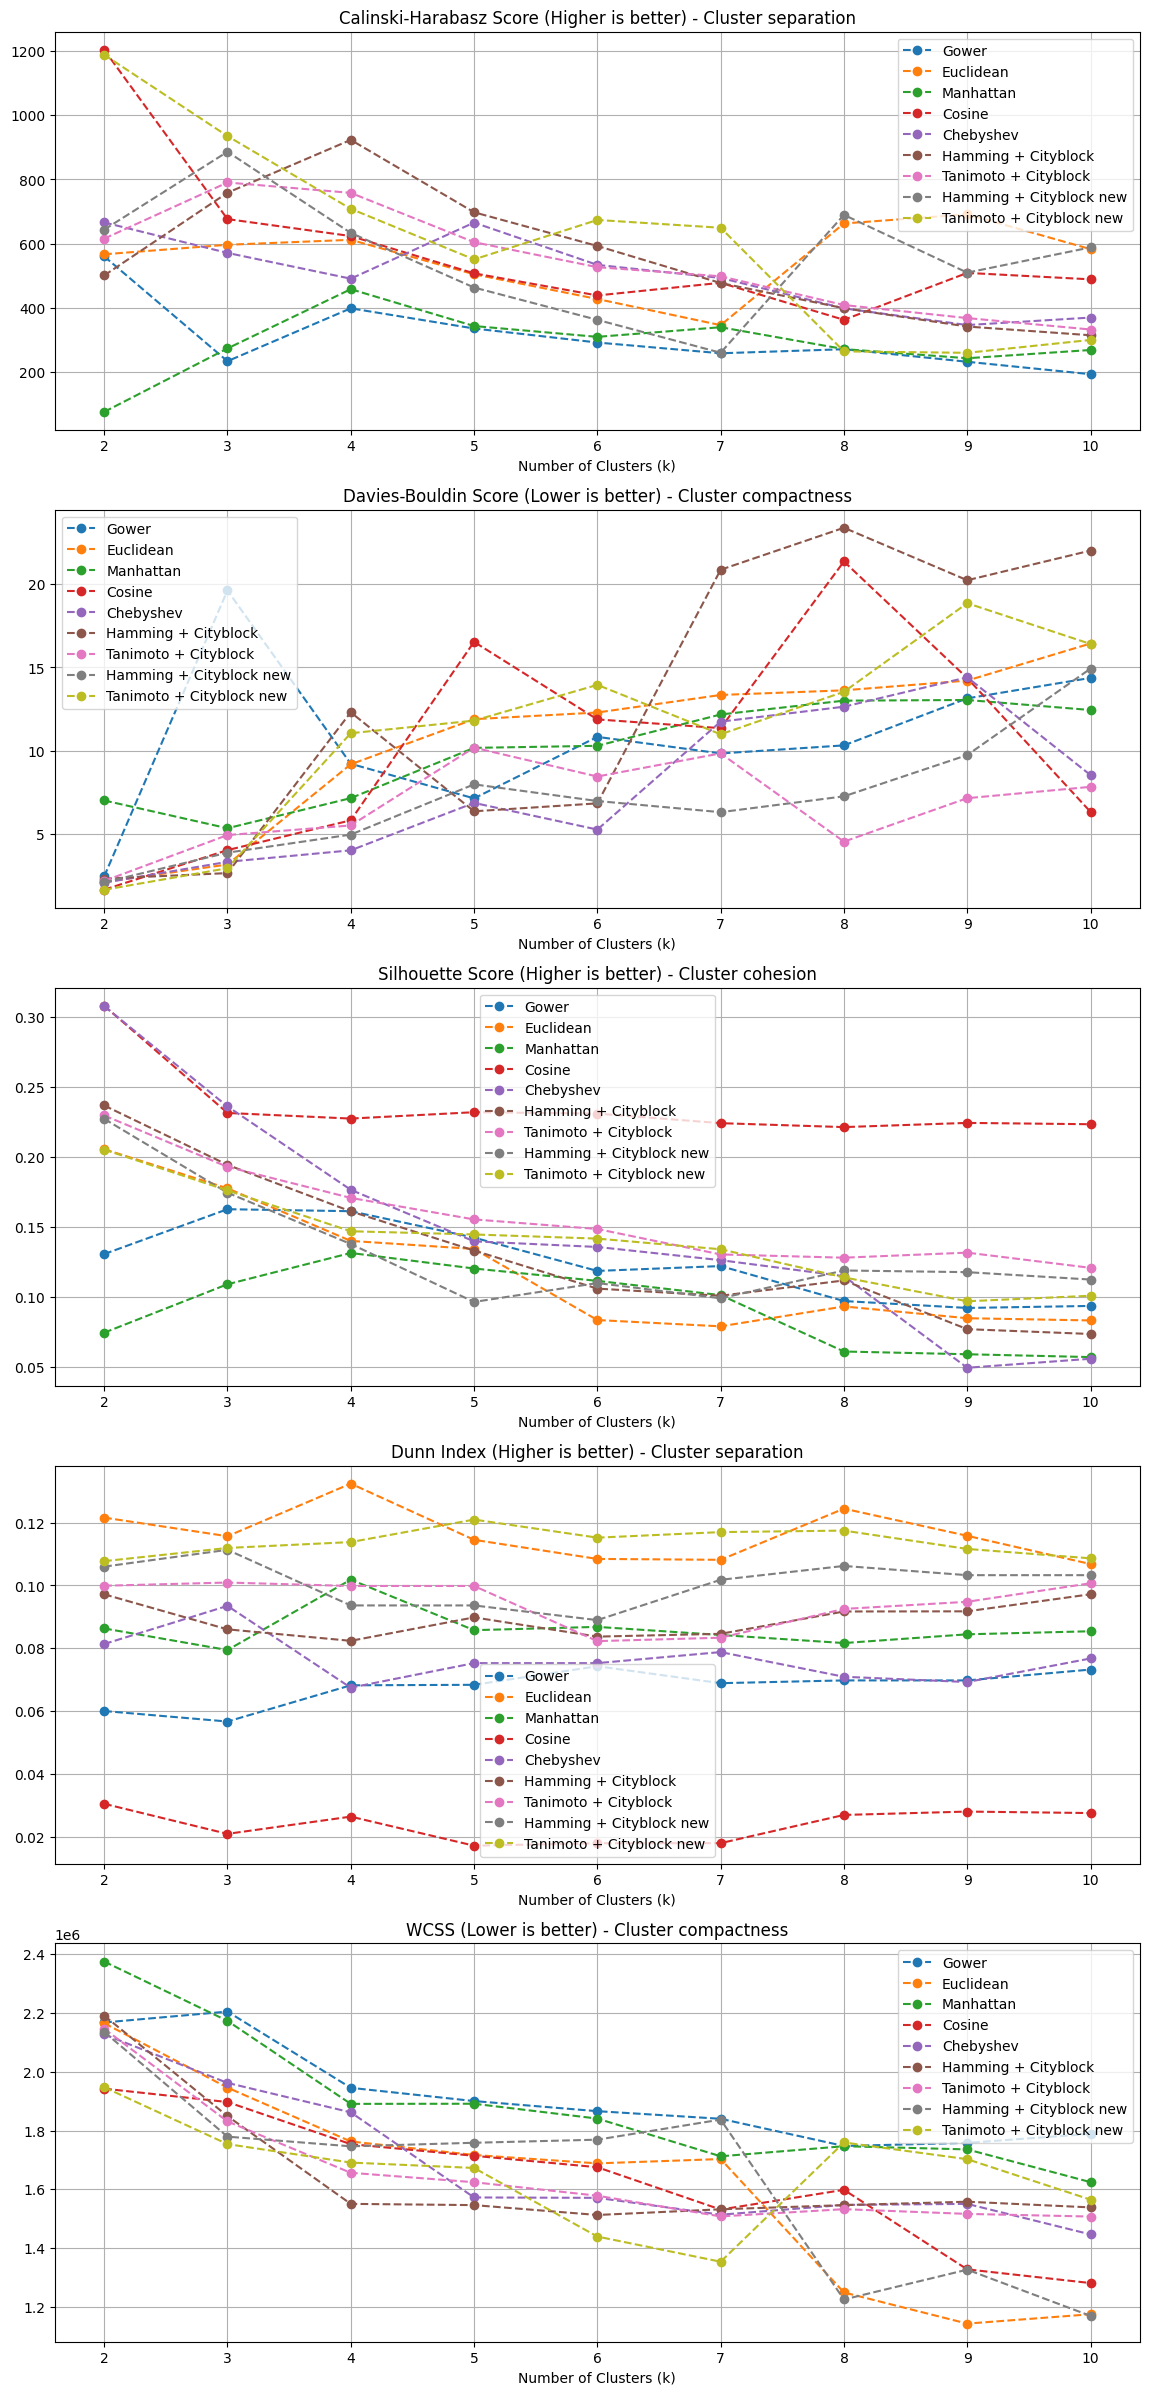


🔹 Best k values for Gower Distance:
✅ Optimal k (CH - Separation): 2
✅ Optimal k (DB - Compactness): 2
✅ Optimal k (Silhouette - Cohesion): 3
✅ Optimal k (Dunn - Separation): 6
✅ Optimal k (WCSS - Compactness, Elbow Expected): 8

🔹 Best k values for Euclidean Distance:
✅ Optimal k (CH - Separation): 9
✅ Optimal k (DB - Compactness): 2
✅ Optimal k (Silhouette - Cohesion): 2
✅ Optimal k (Dunn - Separation): 4
✅ Optimal k (WCSS - Compactness, Elbow Expected): 9

🔹 Best k values for Manhattan Distance:
✅ Optimal k (CH - Separation): 4
✅ Optimal k (DB - Compactness): 3
✅ Optimal k (Silhouette - Cohesion): 4
✅ Optimal k (Dunn - Separation): 4
✅ Optimal k (WCSS - Compactness, Elbow Expected): 10

🔹 Best k values for Cosine Distance:
✅ Optimal k (CH - Separation): 2
✅ Optimal k (DB - Compactness): 2
✅ Optimal k (Silhouette - Cohesion): 2
✅ Optimal k (Dunn - Separation): 2
✅ Optimal k (WCSS - Compactness, Elbow Expected): 10

🔹 Best k values for Chebyshev Distance:
✅ Optimal k (CH - Separation

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score
from scipy.spatial.distance import pdist

# Compute Dunn Index
def dunn_index(dist_matrix, labels):
    unique_clusters = np.unique(labels)
    intra_dists = []
    inter_dists = []

    for cluster in unique_clusters:
        cluster_points = np.where(labels == cluster)[0]
        other_points = np.where(labels != cluster)[0]

        intra_dists.append(np.max(dist_matrix[np.ix_(cluster_points, cluster_points)]))
        inter_dists.append(np.min(dist_matrix[np.ix_(cluster_points, other_points)]))

    return np.min(inter_dists) / np.max(intra_dists)

# Compute Cohesion & Separation
def cohesion_separation(X, labels):
    unique_clusters = np.unique(labels)
    cohesion = sum([np.nansum(pdist(X[labels == cluster])) for cluster in unique_clusters])
    separation = sum([np.nansum(pdist(X[labels != cluster])) for cluster in unique_clusters])
    return cohesion, separation

# Compute WCSS (Within-Cluster Sum of Squares)
def compute_wcss(X, labels):
    unique_clusters = np.unique(labels)
    wcss = sum([np.nansum((X[labels == cluster] - np.nanmean(X[labels == cluster], axis=0)) ** 2) for cluster in unique_clusters])
    return wcss

# Evaluate clustering for all distance metrics
def evaluate_clustering(X, cluster_results, distance_matrices):
    metrics = ["Gower", "Euclidean", "Manhattan", "Cosine", "Chebyshev", "Hamming + Cityblock", "Tanimoto + Cityblock", "Hamming + Cityblock new","Tanimoto + Cityblock new" ]

    # Store scores for each metric
    scores = {metric: {"CH": [], "DB": [], "Silhouette": [], "Dunn": [], "WCSS": []} for metric in metrics}

    for metric in metrics:
        print(f"\n🔹 Evaluating Clustering Performance for {metric} Distance")
        k_values = list(cluster_results[metric].keys())

        for k in k_values:
            labels = cluster_results[metric][k]
            distance_matrix = distance_matrices[metric]

            try:
                scores[metric]["CH"].append(calinski_harabasz_score(df, labels))
                scores[metric]["DB"].append(davies_bouldin_score(df, labels))
                scores[metric]["Silhouette"].append(silhouette_score(distance_matrix, labels, metric='precomputed'))
                scores[metric]["Dunn"].append(dunn_index(distance_matrix, labels))
                scores[metric]["WCSS"].append(compute_wcss(df, labels))
            except ValueError as e:
                print(f"⚠️ Skipping k={k} for {metric} due to an error: {e}")
                scores[metric]["CH"].append(np.nan)
                scores[metric]["DB"].append(np.nan)
                scores[metric]["Silhouette"].append(np.nan)
                scores[metric]["Dunn"].append(np.nan)
                scores[metric]["WCSS"].append(np.nan)

    # Plot metrics for comparison
    fig, axes = plt.subplots(5, 1, figsize=(14, 30))  # Increased figure size for clarity
    metric_details = [
        ("Calinski-Harabasz Score (Higher is better) - Cluster separation", "CH"),
        ("Davies-Bouldin Score (Lower is better) - Cluster compactness", "DB"),
        ("Silhouette Score (Higher is better) - Cluster cohesion", "Silhouette"),
        ("Dunn Index (Higher is better) - Cluster separation", "Dunn"),
        ("WCSS (Lower is better) - Cluster compactness", "WCSS")
    ]

    for idx, (metric_name, score_key) in enumerate(metric_details):
        for metric in metrics:
            valid_scores = np.array(scores[metric][score_key])
            valid_k_values = np.array(k_values)[~np.isnan(valid_scores)]  # Remove NaN values
            valid_scores = valid_scores[~np.isnan(valid_scores)]

            axes[idx].plot(valid_k_values, valid_scores, marker='o', linestyle='--', label=metric)

        axes[idx].set_title(metric_name)
        axes[idx].set_xlabel("Number of Clusters (k)")
        axes[idx].grid(True)
        axes[idx].legend(loc='best', fontsize=10)  # Each plot has its own legend

    plt.show()

    # Find the best k for each distance metric
    for metric in metrics:
        print(f"\n🔹 Best k values for {metric} Distance:")
        print(f"✅ Optimal k (CH - Separation): {k_values[np.argmax(scores[metric]['CH'])]}")
        print(f"✅ Optimal k (DB - Compactness): {k_values[np.argmin(scores[metric]['DB'])]}")
        print(f"✅ Optimal k (Silhouette - Cohesion): {k_values[np.argmax(scores[metric]['Silhouette'])]}")
        print(f"✅ Optimal k (Dunn - Separation): {k_values[np.argmax(scores[metric]['Dunn'])]}")
        print(f"✅ Optimal k (WCSS - Compactness, Elbow Expected): {k_values[np.argmin(scores[metric]['WCSS'])]}")

    return scores

# Evaluate clustering for all distance metrics
clustering_scores = evaluate_clustering(df, cluster_results, distance_matrices)

In [15]:
from sklearn.manifold import TSNE
import plotly.graph_objects as go
import pandas as pd
import numpy as np

# Use Euclidean distance with 4 clusters
distance_metric = "Tanimoto + Cityblock new"
num_clusters = 3

dist_matrix = distance_matrices[distance_metric]

# Check if the distance matrix is valid
if np.isnan(dist_matrix).any() or np.isinf(dist_matrix).any():
    raise ValueError(f"⚠️ {distance_metric} distance matrix contains NaN or Inf values. Check your preprocessing!")

if dist_matrix.shape[0] != dist_matrix.shape[1]:
    raise ValueError(f"⚠️ {distance_metric} distance matrix must be square (NxN).")

# Check if the selected number of clusters exists
if num_clusters not in cluster_results[distance_metric]:
    raise ValueError(f"⚠️ num_clusters={num_clusters} is not in cluster_results[{distance_metric}]. Check clustering output!")

labels = cluster_results[distance_metric][num_clusters]

# Compute 3D t-SNE projection
tsne = TSNE(n_components=3, metric='precomputed', init='random', random_state=42)
X_tsne_3d = tsne.fit_transform(dist_matrix)

# Create DataFrame for visualization
df_plot = pd.DataFrame({'x': X_tsne_3d[:, 0], 'y': X_tsne_3d[:, 1], 'z': X_tsne_3d[:, 2], 'Cluster': labels})

# Generate interactive 3D scatter plot
fig = go.Figure(data=[
    go.Scatter3d(
        x=df_plot['x'],
        y=df_plot['y'],
        z=df_plot['z'],
        mode='markers',
        marker=dict(
            size=5,  # Explicitly setting the size
            color=df_plot['Cluster'],  # Color by cluster
            colorscale='Turbo',  # Set color scale
            opacity=0.7  # Adjust transparency
        )
    )
])

# Customize layout
fig.update_layout(
    title=f"3D t-SNE Cluster Visualization ({distance_metric} Distance, k={num_clusters})",
    scene=dict(
        xaxis_title="t-SNE 1",
        yaxis_title="t-SNE 2",
        zaxis_title="t-SNE 3",
        aspectmode="cube"  # Keeps the aspect ratio balanced
    ),
    margin=dict(l=0, r=0, b=0, t=50),
    width=800,  # Adjusted figure width
    height=800   # Adjusted figure height
)

fig.show()

In [16]:
import pandas as pd
from IPython.display import display
import numpy as np

# Ensure OneHotEncoder is fitted before retrieving feature names
if not hasattr(encoder, 'get_feature_names_out'):
    raise ValueError("⚠️ Encoder is not fitted. Ensure OneHotEncoder is properly trained before extracting feature names.")

# Get the actual feature names from OneHotEncoder
encoded_feature_names = encoder.get_feature_names_out(input_features=categorical_columns)
numerical_feature_names = [f'PCA_{i+1}' for i in range(X_pca.shape[1])]  # PCA transformed features
all_feature_names = numerical_feature_names + list(encoded_feature_names)

# Auto-adjust feature name list if mismatched
if len(all_feature_names) != X_preprocessed.shape[1]:
    print(f"⚠️ Adjusting feature names dynamically: {len(all_feature_names)} names vs {X_preprocessed.shape[1]} columns.")
    all_feature_names = all_feature_names[:X_preprocessed.shape[1]]

# Convert back to DataFrame with proper labels
cluster_summary = pd.DataFrame(X_preprocessed, columns=all_feature_names)
cluster_summary['Cluster'] = labels

# Compute mean of each feature per cluster
summary = cluster_summary.groupby('Cluster').mean()

# Reverse Standard Scaling to restore original numerical values
summary_original_scale = summary.copy()
if len(numerical_feature_names) == scaler.n_features_in_:
    try:
        summary_original_scale[numerical_feature_names] = scaler.inverse_transform(summary[numerical_feature_names])
        # Clip unrealistic values (e.g., age)
        if 'Age' in summary_original_scale.columns:
            summary_original_scale['Age'] = summary_original_scale['Age'].clip(lower=18, upper=100)
    except ValueError as e:
        print(f"⚠️ Error in inverse transformation: {e}. Skipping numerical rescaling.")

# Convert one-hot encoded categorical values back to original labels using inverse_transform()
try:
    categorical_decoded = encoder.inverse_transform(summary[encoded_feature_names])
    summary_original_scale[categorical_columns] = pd.DataFrame(categorical_decoded, index=summary.index, columns=categorical_columns)
    summary_original_scale.drop(columns=encoded_feature_names, errors='ignore', inplace=True)
except Exception as e:
    print(f"⚠️ Error decoding categorical values: {e}")

# Display the DataFrame as a readable table
print("🔹 Cluster Characteristics (Original Scale with Categorical Labels Restored):")
display(summary_original_scale)

🔹 Cluster Characteristics (Original Scale with Categorical Labels Restored):


,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,Gender,Job,Area,CitySize,Investments
Cluster,,,,,,,,,,,,,,,
0,2.653130,-0.441078,-0.036630,-0.092735,0.094572,0.003654,-0.119613,-0.026600,0.008509,-0.004352,1,2,2,3,3
1,-2.511569,-0.770920,0.239877,-0.074743,-0.046191,-0.085741,-0.042793,-0.020281,0.036294,0.012464,1,5,2,2,2
2,-0.162556,0.655802,-0.106321,0.091671,-0.028722,0.043309,0.089876,0.025682,-0.023985,-0.004148,1,2,2,2,3
